# BRD-4 Exploratory Data Analysis

# Setup Code
## Environment

In [1]:
import sys

print(sys.executable)

/home/oskar/anaconda3/envs/brd4/bin/python


## Imports

In [2]:
### Standard imports
import copy
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Access ChEMBL
from chembl_webresource_client.new_client import new_client

### Standard Cheminformatics imports
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors, PandasTools
from tqdm import tqdm

## Jupyter Settings

In [3]:
### Suppress RDKit logs
RDLogger.DisableLog("rdApp.*")

### Re-enable logging if needed
# RDLogger.EnableLog('rdApp.*')


### NumPy arrays - floats
np.set_printoptions(
    precision=2,  # round values
    suppress=True,
)  # avoid scientific notation

### pandas DataFrames
pd.set_option("display.float_format", "{:.3f}".format)  # Round to 2 decimal places

### To track progress of slow code
tqdm.pandas()  # Initialize tqdm for pandas

## Utils
- `utils/pd_mol.py` contains individual functions for processing rdkit mol objects in pandas DataFrames

In [4]:
### Add the utils directory to the path
sys.path.append(os.path.abspath("../utils"))
import pd_mol
from pd_mol import render_mol

## Functions

In [5]:
def keep_closest_to_median(group, act_column="standard_value"):
    """
    Selects the row where the activity value is closest to the median
    for a given group.

    Parameters:
        group (pd.DataFrame): A DataFrame containing multiple rows corresponding to a single `molecule_chembl_id` group.
        act_column (str) The name of the column containing the bioactivity values.

    Returns:
        row (pd.Series): The row with the activity value closest to the median of the group.
    """
    median_value = group[act_column].median()  # Compute median for the group
    return group.loc[(group[act_column] - median_value).abs().idxmin()]


# Import BRD4 Data from ChEMBL

In [6]:
### List all tables
available_resources = [
    resource for resource in dir(new_client) if not resource.startswith("_")
]
print("\n".join(available_resources))

activity
activity_supplementary_data_by_activity
assay
assay_class
atc_class
binding_site
biotherapeutic
cell_line
chembl_id_lookup
chembl_release
compound_record
compound_structural_alert
description
document
document_similarity
drug
drug_indication
drug_warning
go_slim
image
mechanism
metabolism
molecule
molecule_form
official
organism
protein_classification
similarity
source
substructure
target
target_component
target_relation
tissue
xref_source


In [7]:
### Create resource objects for API access
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity
type(targets_api)

chembl_webresource_client.query_set.QuerySet

## Get target data

* Get UniProt ID of the target of interest from [UniProt website](https://www.uniprot.org/)
* Use UniProt ID to get target information

In [8]:
### UniProtID for BRD4
uniprot_id = "O60885"

In [9]:
### Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


In [10]:
### List all ChEMBL targets associated with the given UniProtID
targets_df = pd.DataFrame.from_records(targets)
targets_df.head()

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Bromodomain-containing protein 4,CHEMBL1163125,SINGLE PROTEIN
1,Homo sapiens,Bromodomain-containing protein 4,CHEMBL1163125,SINGLE PROTEIN
2,Homo sapiens,BRD4/HDAC1,CHEMBL4106143,PROTEIN COMPLEX
3,Homo sapiens,Cereblon/Cullin-4A/Bromodomain-containing prot...,CHEMBL4296133,PROTEIN-PROTEIN INTERACTION
4,Homo sapiens,Cereblon/Bromodomain-containing protein 4,CHEMBL4296138,PROTEIN-PROTEIN INTERACTION


In [11]:
### Select target (target_ChEMBL_ID) - it's usually the first one
target_df = targets_df.iloc[0]
target_df

organism                                Homo sapiens
pref_name           Bromodomain-containing protein 4
target_chembl_id                       CHEMBL1163125
target_type                           SINGLE PROTEIN
Name: 0, dtype: object

In [12]:
### Save selected ChEMBL ID
chembl_id = target_df.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")

The target ChEMBL ID is CHEMBL1163125


## Get bioactivity data

Fetch the bioactivity data and filter it to only consider

* human proteins, 
* bioactivity type IC50, 
* exact measurements (relation `'='`), and
* binding data (assay type `'B'`).

In [13]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(
    f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}"
)

Length and type of bioactivities object: 4252, <class 'chembl_webresource_client.query_set.QuerySet'>


Each entry in our bioactivity set holds the following information:

In [14]:
print(
    f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}"
)
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 6364731,
 'assay_chembl_id': 'CHEMBL1832996',
 'assay_description': 'Displacement of H4Ac4 peptide from first bromodomain of human BRD4 by peptide displacement assay',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL1828978',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '4800.0',
 'target_chembl_id': 'CHEMBL1163125',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '4.8'}

Download the `QuerySet` in the form of a `pandas` `DataFrame`. 

> **Note**: This step should not take more than 2 minutes, if so try to rerun all cells in this chapter

In [15]:
### Download data - read above
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")

### Drop redundant columns
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

DataFrame shape: (4252, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,6364731,CHEMBL1832996,Displacement of H4Ac4 peptide from first bromo...,B,CHEMBL1828978,=,nM,4800.0,CHEMBL1163125,Homo sapiens,IC50
1,6364732,CHEMBL1832996,Displacement of H4Ac4 peptide from first bromo...,B,CHEMBL1828979,=,nM,84200.0,CHEMBL1163125,Homo sapiens,IC50
2,6364733,CHEMBL1832996,Displacement of H4Ac4 peptide from first bromo...,B,CHEMBL1828980,=,nM,24600.0,CHEMBL1163125,Homo sapiens,IC50
3,6364734,CHEMBL1832996,Displacement of H4Ac4 peptide from first bromo...,B,CHEMBL1828981,=,nM,23200.0,CHEMBL1163125,Homo sapiens,IC50
4,6364735,CHEMBL1832996,Displacement of H4Ac4 peptide from first bromo...,B,CHEMBL1828982,=,nM,9700.0,CHEMBL1163125,Homo sapiens,IC50


In [16]:
bioactivities_df["standard_units"].unique()

array(['nM', '10^2 uM'], dtype=object)

### Preprocess and filter bioactivity data

1. Convert `standard_value`'s datatype from `object` to `float`
2. Delete entries with missing values
3. Keep only entries with `standard_unit == nM`
4. Delete duplicate molecules
5. Reset `DataFrame` index
6. Rename columns

**1. Convert datatype of "standard_value" from "object" to "float"**

The field `standard_value` holds standardized (here IC50) values. In order to make these values usable in calculations later on, convert values to floats.

In [17]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

**2. Delete entries with missing values**

In [18]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (4252, 11)


**3. Keep only entries with "standard_unit == nM"** 

In [19]:
### Metrics on units
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

### Drop non-nM entries
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"DataFrame shape after subsetting: {bioactivities_df.shape}")

Units in downloaded data: ['nM' '10^2 uM']
Number of non-nM entries:    13
DataFrame shape after subsetting: (4239, 11)


**4. Delete duplicate molecules**

Often the same molecule (`molecule_chembl_id`) has been tested more than once. In these cases, the entry closest to the median for this id is kept.

`Note:` other choices could be to keep the first entry, the one with the best/lowest value or a mean/median value of all assay results for the respective compound.

In [20]:
### Unique molecule_chembl_id values
print(
    f"Number of molecule_chembl_id values: {bioactivities_df['molecule_chembl_id'].nunique()}"
)


### Apply the function to remove duplicates by molecule_chembl_id
bioactivities_df = bioactivities_df.groupby(
    "molecule_chembl_id", group_keys=False
).apply(keep_closest_to_median)

### Reset the index
bioactivities_df.reset_index(drop=True, inplace=True)
print(f"DataFrame shape after filtering: {bioactivities_df.shape}")
bioactivities_df

Number of molecule_chembl_id values: 3057
DataFrame shape after filtering: (3057, 11)


/tmp/ipykernel_22496/3765842411.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(keep_closest_to_median)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,25445894,CHEMBL5317664,Inhibition of BRD4-BD1 (unknown origin) by flu...,B,CHEMBL1097107,=,nM,556.200,CHEMBL1163125,Homo sapiens,IC50
1,12134097,CHEMBL2183681,Inhibition of BRD4 isoform 1 by AlphaScreen assay,B,CHEMBL1230189,=,nM,39000.000,CHEMBL1163125,Homo sapiens,IC50
2,15613371,CHEMBL3584940,Displacement of FAM-labeled ZBA248 from BRD4 B...,B,CHEMBL1232461,=,nM,98.400,CHEMBL1163125,Homo sapiens,IC50
3,25521641,CHEMBL5337544,Inhibition of BRD4 (unknown origin) using BET ...,B,CHEMBL1233528,=,nM,119.800,CHEMBL1163125,Homo sapiens,IC50
4,13972330,CHEMBL3136026,Inhibition of BRD4(1) (unknown origin) by Alph...,B,CHEMBL12543,=,nM,6000000.000,CHEMBL1163125,Homo sapiens,IC50
...,...,...,...,...,...,...,...,...,...,...,...
3052,25562269,CHEMBL5349002,Inhibition of BRD4 BD1 (unknown origin) by TR-...,B,CHEMBL5440963,=,nM,10.000,CHEMBL1163125,Homo sapiens,IC50
3053,20663263,CHEMBL4618785,Inhibition of BRD4 bromodomain 2 (unknown orig...,B,CHEMBL848,=,nM,5190.000,CHEMBL1163125,Homo sapiens,IC50
3054,25007370,CHEMBL5235458,Inhibition of BRD4 (unknown origin),B,CHEMBL9,=,nM,980.000,CHEMBL1163125,Homo sapiens,IC50
3055,24661154,CHEMBL5096331,Inhibition of BRD4 (unknown origin) by ELISA,B,CHEMBL98,=,nM,43.130,CHEMBL1163125,Homo sapiens,IC50


**6. Rename columns**

In [21]:
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (3057, 11)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,25445894,CHEMBL5317664,Inhibition of BRD4-BD1 (unknown origin) by flu...,B,CHEMBL1097107,=,nM,556.200,CHEMBL1163125,Homo sapiens,IC50
1,12134097,CHEMBL2183681,Inhibition of BRD4 isoform 1 by AlphaScreen assay,B,CHEMBL1230189,=,nM,39000.000,CHEMBL1163125,Homo sapiens,IC50
2,15613371,CHEMBL3584940,Displacement of FAM-labeled ZBA248 from BRD4 B...,B,CHEMBL1232461,=,nM,98.400,CHEMBL1163125,Homo sapiens,IC50
3,25521641,CHEMBL5337544,Inhibition of BRD4 (unknown origin) using BET ...,B,CHEMBL1233528,=,nM,119.800,CHEMBL1163125,Homo sapiens,IC50
4,13972330,CHEMBL3136026,Inhibition of BRD4(1) (unknown origin) by Alph...,B,CHEMBL12543,=,nM,6000000.000,CHEMBL1163125,Homo sapiens,IC50


The set now has **3057** unique molecule ids with respective IC50 values for BRD4.

## Get compound data

We have a `DataFrame` containing all molecules tested against BRD4 (with the respective measured bioactivity). 

Now, we want to get the molecular structures of the molecules that are linked to respective bioactivity ChEMBL IDs. 

### Fetch compound data from ChEMBL

Let's have a look at the compounds from ChEMBL which we have defined bioactivity data for: We fetch compound ChEMBL IDs and structures for the compounds linked to our filtered bioactivity data.

In [22]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

### Download compound data from ChEMBL

Again, we want to export the `QuerySet` object into a `pandas.DataFrame`. Given the data volume, **this can take some time.**

In [23]:
compounds = list(tqdm(compounds_provider))

  3%|▎         | 101/3057 [00:00<00:03, 871.04it/s]

100%|██████████| 3057/3057 [00:01<00:00, 2517.01it/s]


In [24]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")
compounds_df.head()

DataFrame shape: (3057, 2)


,molecule_chembl_id,molecule_structures
0,CHEMBL9,{'canonical_smiles': 'CCn1cc(C(=O)O)c(=O)c2cc(...
1,CHEMBL504,"{'canonical_smiles': 'C[S+](C)[O-]', 'molfile'..."
2,CHEMBL12543,"{'canonical_smiles': 'CN1CCCC1=O', 'molfile': ..."
3,CHEMBL98,{'canonical_smiles': 'O=C(CCCCCCC(=O)Nc1ccccc1...
4,CHEMBL14212,{'canonical_smiles': 'Cc1cccc(Oc2nccc(-c3c(-c4...


### Preprocess and filter compound data

1. Remove entries with missing entries
2. Delete duplicate molecules (by molecule_chembl_id)
3. Get molecules with canonical SMILES

**1. Remove entries with missing molecule structure entry**

In [25]:
print(compounds_df.isna().sum())
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

molecule_chembl_id     0
molecule_structures    1
dtype: int64
DataFrame shape: (3056, 2)


**2. Delete duplicate molecules**

In [26]:
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3056, 2)


**3. Get molecules with canonical SMILES**

So far, we have multiple different molecular structure representations. We only want to keep the canonical SMILES.

In [27]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [28]:
### Extract canonical SMILES provided by ChEMBL
compounds_df["can_smiles"] = compounds_df["molecule_structures"].apply(
    lambda x: x.get("canonical_smiles", None) if isinstance(x, dict) else None
)

### Drop the 'molecule_structures' column
compounds_df.drop("molecule_structures", axis=1, inplace=True)

print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3056, 2)


Sanity check: Remove all molecules without a canonical SMILES string.

In [29]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (3056, 2)


## Merge data
**Summary of compound and bioactivity data**

In [30]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 3057


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [31]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 3056


Index(['molecule_chembl_id', 'can_smiles'], dtype='object')

### Merge both datasets

Merge values of interest from `bioactivities_df` and `compounds_df` in an `output_df` based on the compounds' ChEMBL IDs (`molecule_chembl_id`), keeping the following columns:

* ChEMBL IDs: `molecule_chembl_id`
* SMILES: `smiles`
* units: `units`
* IC50: `IC50`

In [32]:
### Merge DataFrames
df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

### Reset row indices
df.reset_index(drop=True, inplace=True)

print(f"Dataset with {df.shape[0]} entries.")
print(df.dtypes)
df.head(5)

Dataset with 3056 entries.
molecule_chembl_id     object
IC50                  float64
units                  object
can_smiles             object
dtype: object


,molecule_chembl_id,IC50,units,can_smiles
0,CHEMBL1097107,556.200,nM,CC1=C(C)C(=O)O[C@@H]([C@](C)(O)[C@]2(O)CC[C@@]...
1,CHEMBL1230189,39000.000,nM,CN1Cc2ccccc2NC1=O
2,CHEMBL1232461,98.400,nM,CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-...
3,CHEMBL1233528,119.800,nM,CC[C@@H]1C(=O)N(C)c2cnc(Nc3ccc(C(=O)N[C@H]4CC[...
4,CHEMBL12543,6000000.000,nM,CN1CCCC1=O


### Remove units
As we are only using `nM` IC50s we can drop the column and store the information in the value header. 

In [33]:
print(df["units"].unique())

### Drop the 'molecule_structures' column
df.drop("units", axis=1, inplace=True)

### Rename the activity column
df = df.rename(columns={"IC50": "IC50_nM"})
df.head()

['nM']


,molecule_chembl_id,IC50_nM,can_smiles
0,CHEMBL1097107,556.200,CC1=C(C)C(=O)O[C@@H]([C@](C)(O)[C@]2(O)CC[C@@]...
1,CHEMBL1230189,39000.000,CN1Cc2ccccc2NC1=O
2,CHEMBL1232461,98.400,CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-...
3,CHEMBL1233528,119.800,CC[C@@H]1C(=O)N(C)c2cnc(Nc3ccc(C(=O)N[C@H]4CC[...
4,CHEMBL12543,6000000.000,CN1CCCC1=O


# Structure curation
The column `molecule_chembl_id` renamed `ID` will be used as index within this project. 

In [34]:
df = df.rename(columns={"molecule_chembl_id": "ID"})
df = df.set_index("ID")

### Check for index uniqueness - Follow up if False
df.index.is_unique

True

In [35]:
### Generate the 'Mol' column from SMILES strings
smiles_col = "can_smiles"
PandasTools.AddMoleculeColumnToFrame(df, smilesCol=smiles_col, molCol="Mol")

## Structure Standardization

In [36]:
### Overwrite the 'Mol' column with a standardized 'Mol' column using default settings
df["Mol"] = pd_mol.standardize_mol_col(df["Mol"])

largest_frag=True (rdMolStandardize.FragmentParent):


100%|██████████| 3056/3056 [00:04<00:00, 623.80it/s]


remove_charge=True (rdMolStandardize.Uncharger().uncharge):


100%|██████████| 3056/3056 [00:00<00:00, 10863.66it/s]


tautomerize=False (rdMolStandardize.CanonicalTautomer)
normalize=True (rdMolStandardize.Normalize):


100%|██████████| 3056/3056 [00:02<00:00, 1110.55it/s]


remove_stereo=False (rdMolStandardize.Normalize):
cal_2D_coord_default=True (rdDepictor.Compute2DCoords):


100%|██████████| 3056/3056 [00:01<00:00, 2114.96it/s]


cal_2D_coord_deep=False (rdCoordGen.AddCoords):
cleanup=True (rdMolStandardize.Cleanup):


100%|██████████| 3056/3056 [00:04<00:00, 634.15it/s]


## Remove duplicates & standardized smiles
- Overwrites the smiles column with smiles generated from the standardized 'Mol' column in order to create standardized smiles
- Standardaized smiles are used to identify and drop duplicated structures

In [37]:
### Generate standardized SMILES from Mol
df["smiles"] = df["Mol"].apply(lambda x: Chem.MolToSmiles(x))
df["smiles"] = df["smiles"].apply(
    lambda x: Chem.MolStandardize.rdMolStandardize.StandardizeSmiles(x)
)
print("{} duplicated rows found".format(df.duplicated(subset="smiles").sum()))

1 duplicated rows found


2


,IC50_nM,can_smiles,Mol,smiles
ID,,,,
CHEMBL4752538,100.000,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)N1CC...,,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)N1CC...
CHEMBL4778627,100.000,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)N1CC...,,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)N1CC...

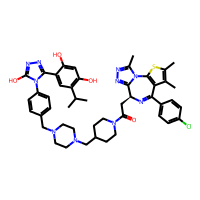
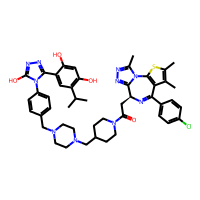

In [38]:
### Visualizing structural duplicates with different ChEMBL IDs for inspection
duplicate_structures_df = df[df.duplicated(subset="smiles", keep=False)]
print(len(duplicate_structures_df))
render_mol(duplicate_structures_df.sort_values("smiles"))

,IC50_nM,Mol
ID,,
CHEMBL1097107,556.200,
CHEMBL1230189,39000.000,
CHEMBL1232461,98.400,
CHEMBL1233528,119.800,
CHEMBL12543,6000000.000,

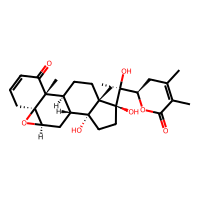
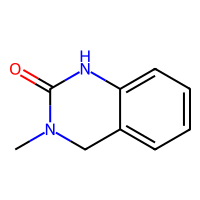
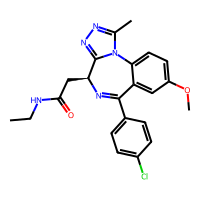
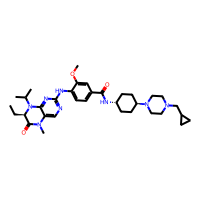
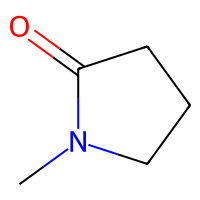

In [39]:
### Remove duplicated rows - keeping the more active records
df = df.drop_duplicates(subset="smiles", keep="first")
df.drop(columns=["can_smiles", "smiles"], inplace=True)
render_mol(df.head())

## Molecular weight
- A range from 250 to 600 g/mol was defined for this project. 
- ChEMBL data with less than 250 g/mol are all can be considered chemical probes rather than inhibitors.
- ChEMBL data with more than 600 g/mol are all heterobifunctional degraders (PROTACs). 

In [40]:
### Calculating molecular weights
df["MW"] = df["Mol"].apply(Descriptors.MolWt)

### Defining cut-offs from visual inspection
lower_cut_off = 200  # cmpds below this threshold can be considered chemical probes, but are not feasible as inhibitors
upper_cut_off = 650  # cmpds above this threshold are exclusively heterobifunctional degraders (PROTACs), and would bias the result

# Saving light and heavy cmpds
df_too_light = df[df["MW"] < lower_cut_off]
df_too_heavy = df[df["MW"] > upper_cut_off]

# subsetting df
df = df[(df["MW"] >= lower_cut_off) & (df["MW"] <= upper_cut_off)]

print(f"{len(df_too_light)} cmpds are too light (chemical probes).")

print(f"{len(df_too_heavy)} cmpds are too heavy (PROTAC degrader).")

print(f"{len(df)} cmpds in data set remaining.")

25 cmpds are too light (chemical probes).
110 cmpds are too heavy (PROTAC degrader).
2920 cmpds in data set remaining.


,IC50_nM,Mol,MW
ID,,,
CHEMBL1230189,39000.000,,162.192
CHEMBL12543,6000000.000,,99.133
CHEMBL1454910,980.000,,190.158

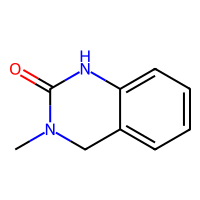
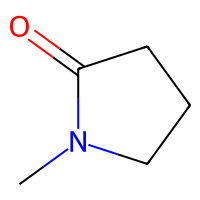
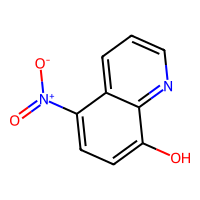

In [41]:
### Chemical probes dropped because of MW filter for visual inspection
render_mol(df_too_light.head(3))

,IC50_nM,Mol,MW
ID,,,
CHEMBL2326966,5300.000,,852.855
CHEMBL4077359,3.100,,1136.239
CHEMBL4303781,80.530,,841.391

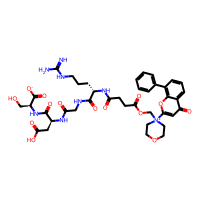
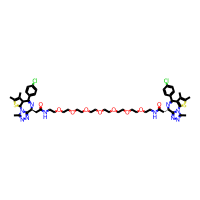
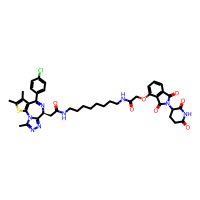

In [42]:
### Bifunctional degraders dropped because of MW filter
render_mol(df_too_heavy.head(3))

In [43]:
### Dropping MW column
del df["MW"]

# Activity labeling
A classification model does not predict the expected IC50 conentration, but classifies molecules in active (1) and inactive (0). Therefore, the training data has to be split accordingly. 

## Add pIC50 values
Logarythmic IC50 are easier to visualize. 

In [44]:
### Apply log conversion
df["pIC50"] = df["IC50_nM"].apply(pd_mol.convert_ic50nM_to_pic50)
del df["IC50_nM"]

In [45]:
df["pIC50"].describe()

count   2920.000
mean       6.401
std        1.140
min        2.155
25%        5.526
50%        6.439
75%        7.184
max        9.620
Name: pIC50, dtype: float64

## Choosing cutoffs

Upper cut-off: 6.75 (0.18 µM)
Lower cut-off: 6.15 (0.71 µM)
----------
4.0-fold cut-off gap
----------
1188 (41%) active cmpds
1209 (41%) inactive cmpds
523 (18%) cmpds not assigned


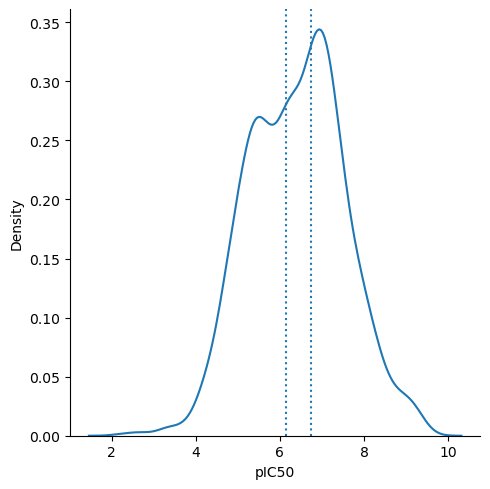

In [46]:
upper_log_cut_off = 6.75
lower_log_cut_off = 6.15

actives = df["pIC50"] >= upper_log_cut_off
inactives = df["pIC50"] <= lower_log_cut_off
dropped = np.logical_and(~actives, ~inactives)

print(
    "Upper cut-off: {:.2f} ({:.2f} µM)".format(
        upper_log_cut_off, 10 ** (6 - upper_log_cut_off)
    )
)
print(
    "Lower cut-off: {:.2f} ({:.2f} µM)".format(
        lower_log_cut_off, 10 ** (6 - lower_log_cut_off)
    )
)
print("----------")
print("{:.1f}-fold cut-off gap".format(10 ** (upper_log_cut_off - lower_log_cut_off)))
print("----------")
print("{} ({:.0f}%) active cmpds".format(actives.sum(), 100 * actives.mean()))
print("{} ({:.0f}%) inactive cmpds".format(inactives.sum(), 100 * inactives.mean()))
print("{} ({:.0f}%) cmpds not assigned".format(dropped.sum(), 100 * dropped.mean()))

### Distribution of activity by IC50
sns.displot(x="pIC50", data=df, kind="kde")
plt.axvline(x=upper_log_cut_off, linestyle="dotted")
plt.axvline(x=lower_log_cut_off, linestyle="dotted")
plt.show()

**Comments**

Choosing a cut-off is not an obvious task. 

- On one hand "only" a 4-fold IC50-gap between actives and inactives is quite narrow and will cause some raised eye-brows among MedChemists. 
- On the other dropping 18% of precious training data hurts (especially in ML engeneers hearts). 
- So with no-one happy, we found a good compromise. 
- Splitting actives and inactives into two groups of equal size, will make things with QSAR model construction. 

`Note:` for a new data set or with little understanding of the distribution IC50 (pIC50) values of 5.3 (5 µM) and 4.7 (20 µM) are good starting points to use as cut-offs. 

## Adding a boolean activity classifier

In [47]:
df["active"] = np.nan
df.loc[actives, "active"] = 1
df.loc[inactives, "active"] = 0

print("{} active cmpds".format(int(df["active"].sum())))
print("{} inactive cmpds".format(int((df["active"] == 0).sum())))
print("{} compds not assigned".format(df["active"].isna().sum()))
df

1188 active cmpds
1209 inactive cmpds
523 compds not assigned


,Mol,pIC50,active
ID,,,
CHEMBL1097107,<rdkit.Chem.rdchem.Mol object at 0x72970ca94dd0>,6.255,NaN
CHEMBL1232461,<rdkit.Chem.rdchem.Mol object at 0x72970ca94cf0>,7.007,1.000
CHEMBL1233528,<rdkit.Chem.rdchem.Mol object at 0x72970ca94c80>,6.922,1.000
CHEMBL1287853,<rdkit.Chem.rdchem.Mol object at 0x72970ca94e40>,6.538,NaN
CHEMBL1313432,<rdkit.Chem.rdchem.Mol object at 0x72970ca94eb0>,5.180,0.000
...,...,...,...
CHEMBL5440963,<rdkit.Chem.rdchem.Mol object at 0x72970ca4b060>,8.000,1.000
CHEMBL848,<rdkit.Chem.rdchem.Mol object at 0x72970ca4aff0>,5.285,0.000
CHEMBL9,<rdkit.Chem.rdchem.Mol object at 0x72970ca4af80>,6.009,0.000


# Export Data Sets

## All cmpds

In [48]:
### Write Data to SD-file for inspection with other software
EDA_all_df = copy.deepcopy(df)
EDA_all_df = EDA_all_df.reset_index()
PandasTools.WriteSDF(
    EDA_all_df,
    "../data/01_brd4_all_inhibitors.sdf",
    molColName="Mol",
    idName="ID",
    properties=list(EDA_all_df.columns),
)

In [49]:
### Write pickled file for code development
EDA_all_df.to_pickle("temp/01_brd4_all_inhibitors.pkl")

### Drop cmpds without labels

In [50]:
df = df.dropna()
print("{} unique inhibitors".format(len(df)))
print(
    "{} ({}%) labelled as active".format(
        int(df["active"].sum()), round(100 * df["active"].mean())
    )
)

2397 unique inhibitors
1188 (50%) labelled as active


In [51]:
### Write pickled file for next step
df.to_pickle("../data/01_brd4_inhibitors_2k.pkl")